In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
np.random.seed(0)

# Test mix

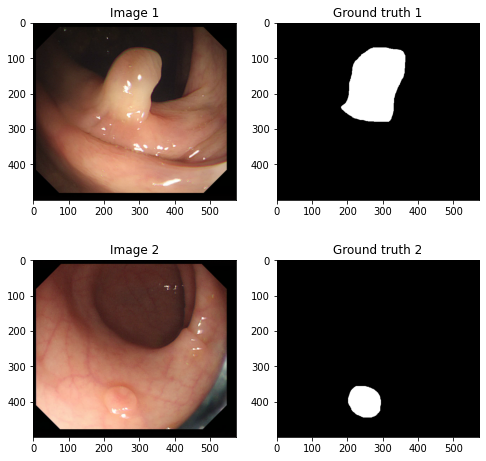

In [2]:
img_path1 = r"dataset\TestDataset\CVC-300\images\149.png"
mask_path1 = r"dataset\TestDataset\CVC-300\masks\149.png"
img_path2 = r"dataset\TestDataset\CVC-300\images\157.png"
mask_path2 = r"dataset\TestDataset\CVC-300\masks\157.png"

img1 = cv2.imread(img_path1, cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gt1 = cv2.imread(mask_path1, cv2.IMREAD_GRAYSCALE)
gt2 = cv2.imread(mask_path2, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1), plt.imshow(img1), plt.title("Image 1")
plt.subplot(2,2,2), plt.imshow(gt1, cmap="gray"), plt.title("Ground truth 1")
plt.subplot(2,2,3), plt.imshow(img2), plt.title("Image 2")
plt.subplot(2,2,4), plt.imshow(gt2, cmap="gray"), plt.title("Ground truth 2")
plt.show()

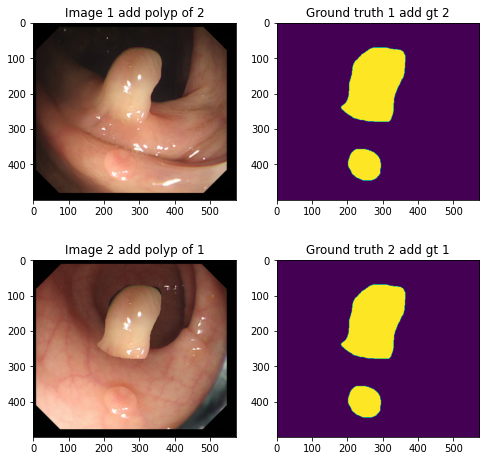

In [4]:
mask1 = gt1 > 0
mask2 = gt2 > 0

img12 = img1.copy()
img21 = img2.copy()

img12[mask2] = img2[mask2]
img21[mask1] = img1[mask1]

gt12 = gt1.copy()
gt12[mask2] = 255
gt21 = gt2.copy()
gt21[mask1] = 255

plt.figure(figsize=(8,8))
plt.subplot(2,2,1), plt.imshow(img12), plt.title("Image 1 add polyp of 2")
plt.subplot(2,2,2), plt.imshow(gt12), plt.title("Ground truth 1 add gt 2")
plt.subplot(2,2,3), plt.imshow(img21), plt.title("Image 2 add polyp of 1")
plt.subplot(2,2,4), plt.imshow(gt21), plt.title("Ground truth 2 add gt 1")
plt.show()

# Mix function

In [99]:
def cutmix(img1, gt1, img2, gt2):
    """
    Resize source to match destination. Then copy polyp from source and paste to destination.
    
    Params:
        img1, gt1: destination
        img2, gt2: source
    """
    height, width = img1.shape[0], img1.shape[1]
    img2 = cv2.resize(img2, dsize=(width, height))
    gt2 = cv2.resize(gt2, dsize=(width, height))

    img_ret = img1.copy()
    gt_ret = gt1.copy()

    mask = gt2 > 128
    img_ret[mask] = img2[mask]
    gt_ret[mask] = gt2[mask]

    # Threshold
    gt_ret[gt_ret >= 128] = 255
    gt_ret[gt_ret < 128] = 0

    return img_ret, gt_ret

## Test mix function work correctly

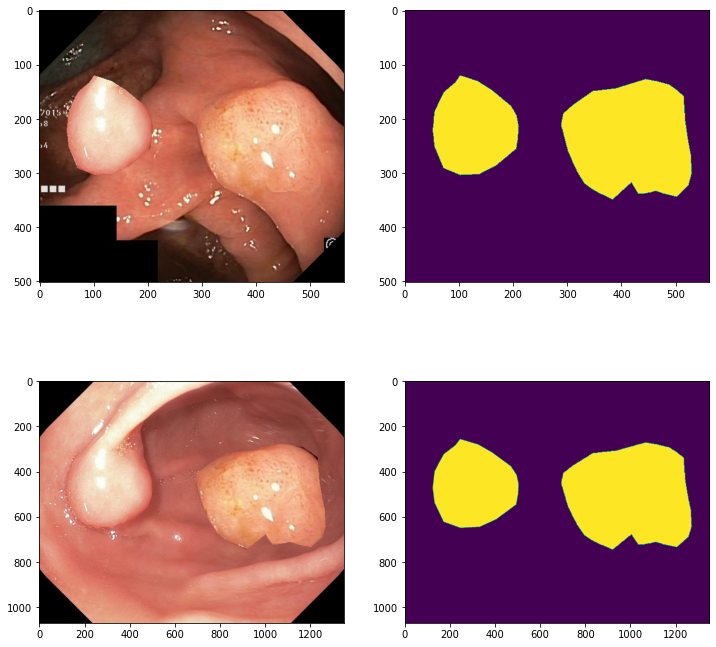

In [100]:
img_path1 = r"dataset\TestDataset\CVC-300\images\149.png"
mask_path1 = r"dataset\TestDataset\CVC-300\masks\149.png"
img_path2 = r"dataset\TestDataset\CVC-300\images\157.png"
mask_path2 = r"dataset\TestDataset\CVC-300\masks\157.png"

img_path1 = r"dataset\TrainDataset\images\cju1hyolc7aqu0878rrkfn1lr.png"
mask_path1 = r"dataset\TrainDataset\masks\cju1hyolc7aqu0878rrkfn1lr.png"
img_path2 = r"dataset\TrainDataset\images\cju1ftaji6isw0855108yqcse.png"
mask_path2 = r"dataset\TrainDataset\masks\cju1ftaji6isw0855108yqcse.png"

img1 = cv2.imread(img_path1, cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gt1 = cv2.imread(mask_path1, cv2.IMREAD_GRAYSCALE)
gt2 = cv2.imread(mask_path2, cv2.IMREAD_GRAYSCALE)

img21, gt21 = cutmix(img1, gt1, img2, gt2)
img12, gt12 = cutmix(img2, gt2, img1, gt1)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1), plt.imshow(img12)
plt.subplot(2,2,2), plt.imshow(gt12)
plt.subplot(2,2,3), plt.imshow(img21)
plt.subplot(2,2,4), plt.imshow(gt21)
plt.show()

# Gen more training data using cutmix

Stategy: Choose random 2 image (img1, img2) from training data. Check if (gt1, gt2) is disjoint then create cutmix(img1, img2).

In [101]:
TRAIN_ROOT = "./dataset/TrainDataset"
imgs = os.listdir(os.path.join(TRAIN_ROOT, "images"))

def create(i, j):
    # Read (img1, gt1)
    filename_1 = imgs[i]
    img_path1 = os.path.join(TRAIN_ROOT, "images", filename_1)
    gt_path1 = os.path.join(TRAIN_ROOT, "masks", filename_1)
    img1 = cv2.imread(img_path1, cv2.IMREAD_COLOR)
    gt1 = cv2.imread(gt_path1, cv2.IMREAD_GRAYSCALE)

    # Read (img2, gt2)
    filename_2 = imgs[j]
    img_path2 = os.path.join(TRAIN_ROOT, "images", filename_2)
    gt_path2 = os.path.join(TRAIN_ROOT, "masks", filename_2)
    img2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)
    gt2 = cv2.imread(gt_path2, cv2.IMREAD_GRAYSCALE)

    # Check if gt1 and gt2 are disjoint
    gt2_temp = cv2.resize(gt2, dsize=(gt1.shape[1], gt1.shape[0]))
    gt2_temp[gt2_temp > 0] = 1
    gt1_temp = gt1.copy()
    gt1_temp[gt1_temp > 0] = 1
    mul = gt1_temp + gt2_temp
    if mul.max() > 1:
        return None

    # Create mix image
    img_mix, gt_mix = cutmix(img1, gt1, img2, gt2)

    # Create a filename
    filename_mix = f"{filename_1}.mix.{filename_2}"
    return img_mix, gt_mix, filename_mix

In [102]:
SAVE_ROOT = "./dataset/TrainDataset_synthesis"
save_img_dir = os.path.join(SAVE_ROOT, "images")
save_gt_dir = os.path.join(SAVE_ROOT, "masks")

shutil.rmtree(SAVE_ROOT, ignore_errors=True)
os.makedirs(save_img_dir, exist_ok=True)
os.makedirs(save_gt_dir, exist_ok=True)

In [103]:
n_iters = 1000
counter = 0
for iter in range(n_iters):
    i, j = np.random.choice(len(imgs), size=2)
    result = create(i, j)
    if result != None:
        img_mix, gt_mix, filename_mix = result
        
        # Save image
        img_filename = os.path.join(save_img_dir, filename_mix)
        cv2.imwrite(img_filename, img_mix)
        
        # Save gt
        gt_filename = os.path.join(save_gt_dir, filename_mix)
        cv2.imwrite(gt_filename, gt_mix)

        counter += 1
        print(f"Iter {iter}: Created mix ({i},{j}) {img_filename}")

print("Count mix created:", counter)

Iter 1: Created mix (1216,835) ./dataset/TrainDataset_synthesis\images\cju7dp3dw2k4n0755zhe003ad.png.mix.cju31rb7vb6110801p9rhacuw.png
Iter 2: Created mix (763,1383) ./dataset/TrainDataset_synthesis\images\cju2ueb6j5ado0878vf5md13o.png.mix.cju8bgdmqrksy0801tozdmraa.png
Iter 3: Created mix (1033,277) ./dataset/TrainDataset_synthesis\images\cju5ht88gedbu0755xrcuddcx.png.mix.373.png
Iter 6: Created mix (314,705) ./dataset/TrainDataset_synthesis\images\411.png.mix.cju2pmhtr17a00855cvpelzb0.png
Iter 14: Created mix (1201,755) ./dataset/TrainDataset_synthesis\images\cju7d7aut2a2p0818z4uxc6cd.png.mix.cju2trbpkv0c00988hxla5dzz.png
Iter 31: Created mix (57,291) ./dataset/TrainDataset_synthesis\images\157.png.mix.389.png
Iter 33: Created mix (430,1106) ./dataset/TrainDataset_synthesis\images\530.png.mix.cju6vqarjv7yo0987q4b1btk1.png
Iter 42: Created mix (1167,1251) ./dataset/TrainDataset_synthesis\images\cju7amjna1ly40871ugiokehb.png.mix.cju7f900s2o0k08175gl1giid.png
Iter 43: Created mix (954,79